## Pair Programming Intro Decision Tree

In [31]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')
pd.options.display.max_columns = None

En el pair programming de hoy debéis usar el csv que guardastéis cuando hicistéis el pairprgramming de codificicación (este csv debería tener las variables estadandarizas).
En pairprogramming anteriores ajustastéis vuestro datos a una regresión lineal. El objetivo de hoy es:


In [32]:
df = pd.read_csv('../Datos/vinos_encoding_ordinal.csv', index_col = 0)
df.head(2)

,id,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,mnt_total_sin_vino,mntwines_sin_cero,mnt_wines_box,education_le,marital_le
0,5524,1957,Graduation,Single,0.235696,0,0,04-09-2012,0.307039,635,1.551577,1.679702,2.462147,1.476500,0.843207,0.349414,1.409304,2.51089,-0.550785,0.693904,2.011116,635.0,14.026740,2,3
1,2174,1954,Graduation,Single,-0.235454,1,1,08-03-2014,-0.383664,11,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,-0.168236,-1.110409,-0.56872,-1.166125,-0.130463,-0.845274,11.0,3.141178,2,3


* Ajustar el modelo a un Decision Tree


In [33]:
X = df.drop(["mnt_wines_box", 'mntwines_sin_cero', 'dt_customer', 'education', 'marital_status', 'mntwines'], axis = 1)
y = df["mnt_wines_box"]

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [35]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

Mostramos nuestro árbol sin ningún límite en hiperparámetros:

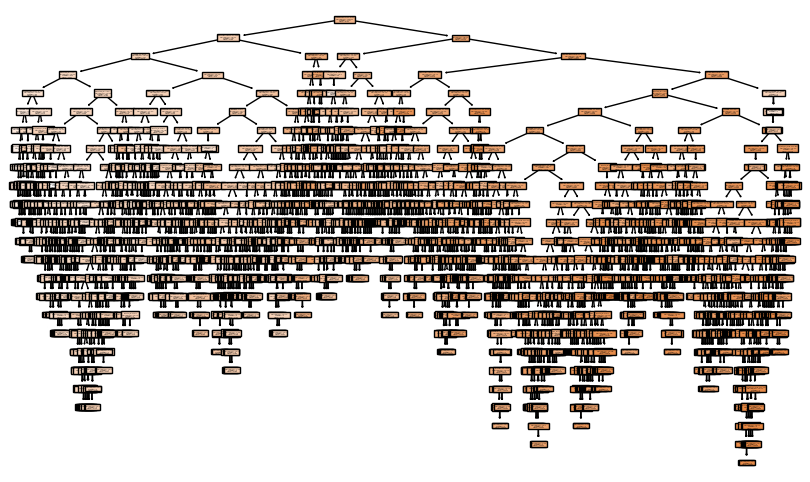

In [36]:
fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol, feature_names = x_train.columns, filled = True)
plt.show()

Seleccionamos hiperparámetros:

In [37]:
#debemos poner en nuestro modelo una profudidad máxima de 5. 
max_features = np.sqrt(len(x_train.columns))
max_features

4.358898943540674

In [38]:
# max depth

print(arbol.tree_.max_depth)

24


In [39]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [40]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df_metricas = pd.DataFrame(resultados)
    df_metricas["modelo"] = tipo_modelo
    return df_metricas

In [41]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,1.363666e+00,4.126976e+00,2.031496e+00,0.831169,test,Decission Tree I
1,1.920587e-18,7.084671e-34,2.661705e-17,1.000000,train,Decission Tree I


Observamos que nuestro modelo nos arroja un 1.0 en R2 por lo que concluimos que tienen overfitting, así que reduciremos la profundidad 

In [42]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param = {"max_depth": [2,4,6,7,8,9], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3,4,5],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 


In [43]:
# una vez creado el diccionario iniciaremos el modelo con GridSearch

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [44]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 6, 7, 8, 9],
                         'max_features': [1, 2, 3, 4, 5],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [45]:
# este método nos esta diciendo que el mejor modelo es aquel que tiene una profundidad de 6, que usa 4 variables predictoras para construir el modelo y que tiene  un min_samples_leaf y un min_samples_split de 10. 
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=8, max_features=5, min_samples_leaf=10,
                      min_samples_split=50)

* Extraer las métricas


* Debatid entre vosotras que modelo es mejor y por qué (basándose en las métricas)